# Identification of Post-Traumatic Sepsis in Critically Ill Trauma Patients from MIMIC-III

This notebook implements a methodology for identifying sepsis onset in a critically ill trauma cohort from the MIMIC-III v1.4 dataset, as detailed in Section 3.2, "Post-trauma Sepsis Definition," of our paper. This work defines, explains, and applies sepsis labeling and onset timestamp determination for the trauma cohort.

Among the 1,570 trauma admissions analyzed, we identified 729 admissions with suspected infections and 535 admissions with confirmed sepsis. Notably, the peak of sepsis onset occurs on the 5th day after hospital admission.

## Background

Sepsis, a life-threatening condition triggered by the body's response to infection, presents significant diagnostic and management challenges, especially in trauma patients. According to the Sepsis-3 consensus guidelines, sepsis is defined as a clinically suspected infection accompanied by acute organ dysfunction. This definition is crucial for identifying sepsis cases within our trauma cohort from MIMIC-III.

Stern et al. (2023) offered a comprehensive framework for defining post-traumatic sepsis, incorporating specific criteria and quality features. However, their work was based on a private dataset. Our approach draws upon their framework while adapting it to the MIMIC-III dataset. This adaptation includes refinements and modifications to align with the unique characteristics and limitations of the MIMIC-III data, ensuring accurate sepsis identification for our cohort.

<!-- The Sepsis-3 guidelines and the Centers for Disease Control and Prevention (CDC) adult sepsis surveillance criteria form the basis of our definition. By integrating these guidelines with the tailored approach from Stern et al., our work aims to address the challenges specific to the MIMIC-III dataset, including data extraction and preprocessing. -->

## Notebook Structure

This notebook is organized into the following sections:

1. **Environment Setup**: Setting up the necessary environment and dependencies for accessing and processing the MIMIC-III v1.4 data.
2. **Preprocessing Feature Tables**: Extracting and preprocessing relevant feature tables from MIMIC-III to identify sepsis cases.
3. **Sepsis Onset Criteria**: Defining and implementing the criteria for sepsis onset.

---

**Note**: This notebook assumes that you have access to MIMIC-III v1.4 on Google BigQuery. If you are unsure or need to apply for access, please refer to the `notebooks/MIMIC_III_Data_Access_Instructions.ipynb` for detailed instructions.

**References**:
- Stern, K., Qiu, Q., Weykamp, M., O’Keefe, G., & Brakenridge, S. C. (2023). Defining posttraumatic sepsis for population-level research. *JAMA Network Open, 6*(1), e2251445. https://doi.org/10.1001/jamanetworkopen.2022.51445



# 0. Environment Setup

## Mount Google Drive
Considering that the overall process may take a long time and Colab execution may be interrupted, we highly recommend mounting your Google Drive to Colab to save intermediate results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [2]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing"

## Importing libraries.

In [3]:
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII

import os
import numpy as np
import pandas as pd
import time
from datetime import datetime
from matplotlib import pyplot as plt

from src.data import data_utils, sql2df, data_fetcher
from scripts.cohort_extraction import extract_trauma_cohort_ids

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII')

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII


# 1. Pre-processing

In the initial phase of our methodology, we preprocess pertinent data to establish the definition of sepsis within the MIMIC-III dataset. This process involves meticulous handling of four primary tables: **cohort admit info**, **blood culture**, **antibiotics**, and **a modified version of the Sequential Organ Failure Assessment (SOFA) score**. The blood culture and antibiotic data are jointly analyzed to identify suspected infections, while the SOFA score is utilized to pinpoint organ dysfunction. This comprehensive preprocessing step ensures accurate and reliable identification of sepsis cases.

## Load Trauma Cohort

This section extracts a cohort of critically ill trauma patients and their corresponding hospital admission information from the MIMIC-III v1.4 dataset. The rationale and detailed explanations of the cohort extraction process, along with other relevant details, can be found in the `'notebooks/cohort_extraction.ipynb'` file.

In [4]:
# Check if the file exists
if os.path.exists(project_path_obj.trauma_cohort_info_path):
    # Load the existing file
    trum_ids = pd.read_csv(project_path_obj.trauma_cohort_info_path, index_col=0)
else:
    # File does not exist, extract cohort IDs and generate statistics report
    trum_ids = extract_trauma_cohort_ids(project_path_obj,    # Saved file paths
                                         PROJECT_ID,          # To query raw data
                                         is_report=True,      # Print statistics report
                                         is_saved=True        # Save the cohort IDs
                                        )

# This table should contain the hospital admission IDs (hadm_id) of trauma patients and the corresponding admission information.
# 1 row per patient
trum_cohort_info_df = trum_ids[['hadm_id', 'admittime', 'dischtime', 'hospital_expire_flag']].drop_duplicates('hadm_id') # we only need Hospital Admission ID,
trum_cohort_info_df['admittime'] = pd.to_datetime(trum_cohort_info_df.admittime)
trum_cohort_info_df['adm_date'] = pd.to_datetime(trum_cohort_info_df.admittime).dt.date
trum_cohort_info_df['disch_date'] = pd.to_datetime(trum_cohort_info_df.dischtime).dt.date
trum_cohort_info_df.head()

,hadm_id,admittime,dischtime,hospital_expire_flag,adm_date,disch_date
0,146828,2186-10-01 23:15:00,2186-10-11 18:00:00,0,2186-10-01,2186-10-11
9,168006,2140-11-06 11:07:00,2140-11-09 20:36:00,1,2140-11-06,2140-11-09
11,103631,2158-06-24 18:50:00,2158-07-21 14:10:00,0,2158-06-24,2158-07-21
15,161310,2173-05-26 02:01:00,2173-06-05 12:45:00,0,2173-05-26,2173-06-05
17,164735,2161-07-01 19:44:00,2161-07-10 20:00:00,0,2161-07-01,2161-07-10



## Blood Cultures

Unlike most studies, we **focus solely on blood cultures** for identifying suspected infections because blood cultures are always part of a panel of samples obtained from patients when sepsis is suspected. When a clinician suspects an infection and possible sepsis but is uncertain of the source or site of the infection, blood cultures are taken along with other body fluid samples. Blood cultures are almost never obtained for surveillance of antibiotic-resistant organisms, whereas other cultures (e.g., tracheal, urine) may be used for this purpose and may not indicate a suspected infection. This focus on blood cultures may result in identifying fewer infections and cases of sepsis compared to using all body fluid cultures, but it is likely more specific to systemic infections crucial for diagnosing sepsis.


Filter blood cultures **at or after 72 hospital hours** to exclude cases of sepsis acquired before hospital admission. Additionally, early culture orders, administered within the first few days, are often part of the standard protocol for managing critically ill patients and do not necessarily indicate an active infection.

**Note**:
We fill missing `CHARTTIME` values with `CHARTDATE` because `CHARTTIME` might be missing when time information is unavailable.


In [ ]:
def extract_blood_cx_events(project_id, trum_cohort_info_df, saved_path=None):
    """
    This function extracts blood culture events for trauma patients from the MicrobiologyEvents table,
    filtering events that occur at or after 72 hospital hours since admission.

    Parameters:
    project_id (str): The BigQuery project ID to query the MIMIC-III v1.4 raw data.
    trum_cohort_info_df (DataFrame): DataFrame containing the hospital admission IDs (hadm_id) of trauma patients along with their corresponding admission information.
    saved_path (str, optional): Path to save the resulting DataFrame as a CSV file. If None, the DataFrame is not saved.

    Returns:
    DataFrame: DataFrame containing the selected columns ('hadm_id', 'cx_datetime', 'cx_hour') for the blood culture events.
    """
    # Query to extract BLOOD culture events from the MicrobiologyEvents file (will missing charttime values with chartdate)
    blood_cx_df = data_utils.run_query("""
        SELECT subject_id, hadm_id, COALESCE(charttime, chartdate) AS charttime
        FROM `physionet-data.mimiciii_clinical.microbiologyevents`
        WHERE spec_itemid = 70012 -- BLOOD CULTURE
        AND hadm_id IS NOT NULL
        ORDER BY hadm_id, charttime;
        """, project_id)

    # Merge with trauma cohort information DataFrame on 'hadm_id'
    trum_blood_cx_df = trum_cohort_info_df.merge(blood_cx_df, on='hadm_id')

    # Extract date & time and calculate hours since admission for each culture event
    trum_blood_cx_df['cx_datetime'] = pd.to_datetime(trum_blood_cx_df['charttime'])
    trum_blood_cx_df['cx_date'] = pd.to_datetime(trum_blood_cx_df['charttime']).dt.date
    trum_blood_cx_df['cx_hour'] = (trum_blood_cx_df['cx_datetime'] - trum_blood_cx_df['admittime']).dt.round("h") // np.timedelta64(1, 'h')
    trum_blood_cx_df['cx_day'] = (trum_blood_cx_df['cx_date'] - trum_blood_cx_df['admittime'].dt.date).apply(lambda x: x.days) + 1

    # Filter to capture entries occurring at or after 72 hospital hours
    trum_blood_cx_df = trum_blood_cx_df[trum_blood_cx_df['cx_hour'] >= 72].sort_values(['hadm_id', 'cx_datetime']).reset_index(drop=True)

    # Save the result to a CSV file if requested
    if saved_path is not None:
        trum_blood_cx_df.to_csv(saved_path)
        print(f"Saved trauma blood culture events to {saved_path}")

    print(f"TOTAL {trum_blood_cx_df.shape[0]} trauma blood culture events for {trum_blood_cx_df['hadm_id'].nunique()} trauma patients")

    # Return a subset of columns for analysis
    return trum_blood_cx_df[['hadm_id', 'cx_datetime', 'cx_day']]

# Example usage:
# trum_blood_cx_df = extract_blood_cx_events(PROJECT_ID, trum_cohort_info_df,
#                                           #  saved_path=project_path_obj.get_processed_data_file('trauma_blood_cx_events.csv')
#                                            )
# # trum_blood_cx_df


## **Antibiotics**

Reproducing relevant sepsis onset work is currently impossible due to the lack of sufficient details on antibiotics data processing and the corresponding implementation code. This results in extreme challenges in reproducing clean, qualified antibiotic records necessary for identifying suspected infections. Furthermore, preprocessing antibiotic data from the Prescriptions table in the MIMIC dataset presents significant challenges due to the absence of standardized antibiotic labels and the disordered nature of the data, which includes overlapping or fragmented entries and inconsistent drug name formats. To address these issues, we meticulously extract relevant orders, consolidate fragmented data into coherent events, and apply sepsis-specific criteria to ensure the accuracy and relevance of the data for defining sepsis onset. This section details the process of extracting and preprocessing raw antibiotic orders from the Prescriptions table, transforming them into clean, well-organized, and qualified antibiotic events crucial for accurately defining sepsis in trauma patients.

<!-- The work will be divided into three sections:

1. **Extract Relevant Antibiotic Order Entries**

2. **Consolidate Order Entries into Events**

3. **Extract Qualified Antibiotic Events (according to sepsis criteria)** -->



### 1. Extract Relevant Antibiotic Order Entries

#### 1.1 Relevant Antibiotic Drug Name

Due to the absence of standardized antibiotic labels and the inconsistent nature of the MIMIC data (e.g., inconsistent drug name formats and poor representation of the drug), relevant data extraction is not readily available. Most existing sepsis onset works overlook this critical challenge and lack a full list of antibiotics they used.

To the best of our knowledge, only two relevant works address the extraction of antibiotics from the Prescriptions table: the [`mimic-iv/.../antibiotic.sql`](https://github.com/MIT-LCP/mimic-code/blob/e58ecabc93b344a2cf02bda485f623d0a03d71ca/mimic-iv/concepts_duckdb/medication/antibiotic.sql#L4) script by the MIT-LCP GitHub project and the [Sepsis Cohort from MIMIC-III](https://github.com/microsoft/mimic_sepsis/blob/main/preprocess.py) by Microsoft. However, neither of these works targets a trauma cohort specifically. The Microsoft project, in particular, extracts antibiotic records using the Generic Sequence Number (GSN) coding system, but multiple GSN codes exist for the same prescription in MIMIC-III. Additionally, their documentation does not provide sufficient details on the included antibiotic drug names to verify the extraction, and the code they include limits antibiotic orders for our trauma cohort.

Therefore, our selection is primarily based on the MIT-LCP GitHub project, which provides a comprehensive list of antibiotics used in MIMIC-IV, and the targeted study on post-traumatic sepsis by Stern et al. (though their work uses a private dataset requiring access). We generate SQL code to extract antibiotics pertinent to sepsis identification for trauma patients. More detailed information, including the full list of antibiotics we include, is documented in our function `abc_sql2df()`.

#### 1.2 Antibiotic Order Cleanup

Based on the antibiotic name selection, we then clean and further filter the qualified antibiotics according to the following criteria:
- **Standardize drug names for consistency**: Convert drug names to lowercase and map different name formats to a single, consistent format (e.g., from `ciprofloxacin iv` to `ciprofloxacin`).
- Exclude antibiotics with irrelevant prefixes such as 'NF' (non-formulary) and desensitization.
- Filter **IV antibiotics**, **excluding prophylactic antibiotics** (such as cefazolin, and optionally excluding ampicillin-sulbactam and erythromycin).
- Filter **two qualified oral antibiotics**: vancomycin and linezolid.
- Extract relevant antibiotic orders specifically for the **trauma cohort**.

In [ ]:
def select_relevant_abx_data(project_id,
                            trum_cohort_info_df):
    """
    Extracts relevant antibiotic related to trauma patients from the Prescriptions table.
    Here is the specific procedure:
    1. Extract and clean antibiotics:
        * Standardize drug names for consistency.
        * Exclude entries with 'desensitization' or 'NF' (non-formulary) prefixes.
    2. Get qualified IV antibiotics
        * excluding certain prophylactic antibiotics:
          cefazolin, and optionally exclude ampicillin-sulbactam and erythromycin.
    3. Get two qualified oral antibiotics: vancomycin and linezolid.
    4. Extract antibiotics specifically for trauma cohort.

    Parameters:
    project_id (str): The BigQuery project ID to query the MIMIC-III v1.4 raw data.
    trum_cohort_info_df (DataFrame): DataFrame containing the hospital admission IDs (hadm_id) of trauma patients along with their corresponding admission information.

    Returns:
    DataFrame: DataFrame containing the cleaned and qualified antibiotics for trauma patients.
    """
    # 1. Extract and clean antibiotics related to post-trauma sepsis from the Prescriptions table
    abx_df = sql2df.abx_sql2df(project_id)
    # Standardize drug name format
    # Convert drug names to lower case
    abx_df.drug = abx_df.drug.apply(str.lower)
    # Exclude antibiotics with 'desensitization' label (not useful for sepsis)
    abx_df = abx_df[~abx_df["drug"].str.contains("desensitization")]
    # Exclude antibiotics with 'NF' (non-formulary) prefix
    abx_df = abx_df[~abx_df["drug"].str.contains("nf")]
    # Map drug names to a single, consistent format
    abx_df.loc[:, 'drug'] = abx_df['drug'].replace({
      'ciprofloxacin iv': 'ciprofloxacin',
      'clindamycin phosphate': 'clindamycin',
      'erythromycin lactobionate': 'erythromycin',
      'gentamicin sulfate': 'gentamicin',
      'metronidazole (flagyl)': 'metronidazole',
      'piperacillin-tazobactam na': 'piperacillin-tazobactam',
      'sulfameth/trimethoprim': 'sulfamethoxazole-trimethoprim',
      'vancomycin enema': 'vancomycin',
      'vancomycin hcl': 'vancomycin',
      'vancomycin oral liquid': 'vancomycin'
      })

    # Columns to select
    cols = ['hadm_id', 'startdate', 'enddate', 'gsn', 'drug', 'drug_name_generic', 'route']

    # 2. Get qualified IV antibiotics
    # Include all antibiotics given IV, excluding certain prophylactic antibiotics
    # iv_antibiotics_df = abx_df[abx_df["route"].str.contains("iv")][cols]
    iv_antibiotics_df = abx_df.loc[abx_df["route"].apply(lambda x: "iv" in str(x).lower()), cols]
    qualified_iv_antibiotics_df = iv_antibiotics_df[~iv_antibiotics_df["drug"].str.contains("cefazolin|sulbactam|erythromycin")]

    # 3. Get qualified oral antibiotics (vancomycin and linezolid)
    oral_route_li = ['PO', 'PO/NG', 'PO OR ENTERAL TUBE', 'PO/OG']
    oral_antibiotics_df = abx_df[abx_df['route'].isin(oral_route_li)][cols]
    qualify_oral_antibiotics_df_van = oral_antibiotics_df[oral_antibiotics_df["drug"].str.contains("vancomycin")][cols]
    qualify_oral_antibiotics_df_lin = oral_antibiotics_df[oral_antibiotics_df["drug"].str.contains("linezolid")][cols]
    qualify_oral_antibiotics_df = pd.concat([qualify_oral_antibiotics_df_van, qualify_oral_antibiotics_df_lin], axis=0)

    # Combine IV and oral antibiotics
    qualify_antibiotics_df = pd.concat([qualified_iv_antibiotics_df, qualify_oral_antibiotics_df], axis=0)
    # print("---SUMMARY---")
    print(f"Included {qualified_iv_antibiotics_df.shape[0]} qualified IV antibiotic samples")
    print('and')
    print(f"Included {qualify_oral_antibiotics_df.shape[0]} qualified oral antibiotic samples")

    # 4. Select antibiotics for trauma patients
    cols.insert(1, 'adm_date')
    cols.insert(2, 'disch_date')
    trum_qualify_antibiotics_df = trum_cohort_info_df.merge(qualify_antibiotics_df, on='hadm_id')[cols]

    # Remove rows with missing data in key columns
    trum_qualify_antibiotics_df = trum_qualify_antibiotics_df.dropna(subset=['hadm_id', 'startdate', 'enddate'])
    print(f"TOTAL {trum_qualify_antibiotics_df.shape[0]} antibiotic samples for {trum_qualify_antibiotics_df.hadm_id.nunique()} trauma patients")

    return trum_qualify_antibiotics_df.sort_values(['hadm_id', 'startdate', 'enddate']).reset_index(drop=True)
# abx = select_relevant_abx_data(PROJECT_ID, trum_cohort_info_df)
# abx.head()

### 2. Consolidate Order Entries into Events

After extracting relevant antibiotics, the next step is to address the problem of overlapping or fragmented time periods by consolidating fragmented data into coherent events. This involves:

1. **Remove data with invalid times**: Exclude entries where the end date is earlier than the start date.
2. **Identify and aggregate orders**: Combine overlapping or continuously segmented orders into a single event based on gaps in orders administration.

In [ ]:
def assign_abx_seq(df):
  """
  This function groups antibiotic orders into sequences,
  where each sequence represents a contiguous period of antibiotic administration,
  The sequence ID is assigned to all orders within a single event.
  A new event is identified based on the `newAbx` column, which marks the beginning of a new sequence.
  """
  newAbx_index = df[df.newAbx==1].index
  n=newAbx_index.size
  for seq, row_ind in enumerate(newAbx_index,1):
    if (seq)==n:
      df.loc[row_ind:df.index[-1],'Abx_seq'] = seq
    else:
      df.loc[row_ind:newAbx_index[seq], 'Abx_seq'] = seq
    # print(seq, row_ind)
  return df

def consolidate_abx_orders(abx_df):
  """
  This function consolidates antibiotic order entries into distinct antibiotic events.
  Specifically, it performs the following steps:

  1. Clean the Raw Antibiotic Order Entries:
    - Remove invalid time data where the end date is earlier than the start date.

  2. Aggregate Order Entries into Event:
    - Identify the starting points for each antibiotic event based on gaps in administration.
      Specifically, a new event is defined when the same drug is not administered on the previous day.
    - Aggregate overlapping or continuous segmented orders into a single event.
  """
  # 1. Clean up records: time period & drug name format
  # Remove invalid records where end date is earlier than start date
  before_drop_noise = abx_df.shape[0]
  noise_data = abx_df.startdate > abx_df.enddate
  clean_abx_df = abx_df[~noise_data]
  print(f"Drop %d noise abx records s.t. startdate>enddate"%(before_drop_noise-clean_abx_df.shape[0]))
  # # standardize drug name format
  # clean_abx_df.loc[:, 'drug'] = clean_abx_df['drug'].replace({
  #   'ciprofloxacin iv': 'ciprofloxacin',
  #   'clindamycin phosphate': 'clindamycin',
  #   'erythromycin lactobionate': 'erythromycin',
  #   'gentamicin sulfate': 'gentamicin',
  #   'metronidazole (flagyl)': 'metronidazole',
  #   'piperacillin-tazobactam na': 'piperacillin-tazobactam',
  #   'sulfameth/trimethoprim': 'sulfamethoxazole-trimethoprim',
  #   'vancomycin enema': 'vancomycin',
  #   'vancomycin hcl': 'vancomycin',
  #   'vancomycin oral liquid': 'vancomycin'
  #   })

  # 2. Assign newAbx: identify the starting points
  new_abx_df = clean_abx_df.sort_values(['hadm_id', 'drug','startdate',	'enddate'])
  new_abx_df['newAbx'] = np.nan #init
  new_abx_df.iloc[0,-1] = 1 # assign newAbx label for first row
  prev_df = new_abx_df.shift(periods=1)
  prev_df.iloc[0] = new_abx_df.iloc[0]
  new_abx_df.loc[new_abx_df.hadm_id != prev_df.hadm_id, 'newAbx'] = 1 # new pacient
  new_abx_df.loc[new_abx_df.drug !=prev_df.drug, 'newAbx'] = 1 # new drug
  diff_day =(new_abx_df.startdate - prev_df.enddate).apply(lambda x: x.days)
  new_abx_df.loc[diff_day>1, 'newAbx'] = 1 # same drug not administered on previous day
  # Group: assigns sequence IDs to antibiotic orders based on identified new orders.
  new_abx_df = new_abx_df.groupby('hadm_id').apply(assign_abx_seq).reset_index(drop=True)
  # Aggregate:
  new_abx_df = new_abx_df.groupby(['hadm_id', 'Abx_seq']).agg({
      # keep the 1st records

      'adm_date': lambda x: x.iloc[0],
      'disch_date': lambda x: x.iloc[0],
      'drug': lambda x: x.iloc[0],
      # keep the widest range
      'startdate': "min",
      'enddate': "max",
  }).reset_index()

  return new_abx_df

### 3. Preprocess Antibiotic Events


This process integrates the preprocessing of antibiotics mentioned in previous sections and applies the final piece of qualified criteria, sepsis-specific criteria, to ensure the accuracy and relevance of the data for defining sepsis onset. The final qualified antibiotic records must meet all the following criteria:

- **Intravenous or Qualifying Oral Antibiotic:** The order must be for an intravenous or qualifying oral antibiotic and not used for surgical prophylaxis.
- **New Order:** The order must be for a new qualifying antibiotic, defined as not administered on the previous day.
- **Not Started on the First Hospital Day**: The antibiotic treatment must not be started on the first day of the hospital stay.
- **Duration of Administration:** The qualifying antibiotic must have been administered for at least 4 consecutive days or until death or discharge.
<!-- Waiting for Dr Grant to give a rationale and citation for this part -->


In [ ]:
def filter_duration_criteria(new_abx_df):
  """
  Filters antibiotic events to ensure they meet the duration criteria.
  The duration criteria are:
    - Antibiotic administration for at least 4 days.
    - Antibiotic administration until death or discharge.

  Parameters:
  new_abx_df (pd.DataFrame): DataFrame containing antibiotic events with start and end dates.
  Returns:
  pd.DataFrame: DataFrame with antibiotic events that meet the duration criteria.
  """
  # Calculate the duration of each antibiotic event in days
  diff_day = (new_abx_df.enddate - new_abx_df.startdate).apply(lambda x: x.days) + 1
  # Check each drug event for duration criteria
  new_abx_df.loc[diff_day >= 4, 'duration_criteria'] = 1 # At least 4 days
  new_abx_df.loc[new_abx_df.enddate >= new_abx_df.disch_date, 'duration_criteria'] = 1 # Until discharge
  # Only include antibiotic events that fit the duration criteria
  new_abx_df = new_abx_df[new_abx_df.duration_criteria ==1]
  return new_abx_df
# new_abx_df = filter_duration_criteria(new_abx_df)

def preprocess_abx_data(project_path_obj,
                        project_id,
                        trum_cohort_info_df,
                        ):
  """
  This function extracts qualified antibiotic orders from the Prescriptions table,
  then cleans and preprocesses the raw antibiotic orders into antibitic events.

  An antibiotic event qualifies if it meets the following criteria:
  * Administered via intravenous (IV) route, or administered orally for specific antibiotic
  * not used for surgical prophylaxis.
  * not administered on the previous day.
  * not started on the first hospital day.
  * administered for at least four consecutive days, or until death or discharge, whichever occurs first.
  """
  # 1.Extract/Load qualify antibiotics order entries for truama cohort
  abx_path = project_path_obj.trauma_abxOrder_path
  if os.path.exists(abx_path):
      abx_df = pd.read_csv(abx_path, index_col=0)
  else:
      abx_df = select_relevant_abx_data(project_id, trum_cohort_info_df)
      abx_df.to_csv(abx_path)
  # extract timestemp for order entries
  abx_df['startdate'] =  pd.to_datetime(abx_df['startdate']).dt.date
  abx_df['enddate'] =  pd.to_datetime(abx_df['enddate']).dt.date
  abx_df = abx_df.drop_duplicates(['hadm_id', 'startdate', 'enddate', 'drug'])
  num_qualifying_antibiotic = abx_df.shape[0]
  print("#of qualifying antibiotic order entries: ", num_qualifying_antibiotic)

  # 2. Consolidates antibiotic order entries into distinct antibiotic events.
  new_abx_df = consolidate_abx_orders(abx_df)
  print("#of qualifying antibiotic event:", new_abx_df.shape)

  # 3.Exclude abx started on the 1st hosipital day
  # Compute anti_day=i: the ith hosipital day that take this antibiotics
  new_abx_df['abx_day'] = (new_abx_df.startdate - new_abx_df.adm_date).apply(lambda x: x.days) + 1
  # fillter
  new_abx_df = new_abx_df[new_abx_df.abx_day > 1]
  new_abx_df['abx_day'] = new_abx_df.abx_day.astype(int)
  print("After droped 1st day antibiotic events:", new_abx_df.shape)

  # 4. Antibiotic Duration Criteria: for at least 4 days or until death or until discharge
  new_abx_df = filter_duration_criteria(new_abx_df)
  print("After filter the duration criteria:", new_abx_df.shape)

  # Sort and reset index(index from 1 instead of 0)
  new_abx_df = new_abx_df.sort_values(['hadm_id','startdate']).reset_index(drop=True)
  new_abx_df.index += 1

  # save
  newAbx_path = project_path_obj.trauma_abxEvent_path
  print(f"Saved clean, well-organized, and qualified antibiotic events to {newAbx_path}")
  new_abx_df.to_csv(newAbx_path)
  return new_abx_df
# new_abx_df = preprocess_abx_data(project_path_obj, PROJECT_ID, trum_cohort_info_df)

## Modified Version of SOFA Score

We now focus on calculating the final piece of the relevant feature table, the SOFA score, to define sepsis onset. We use a modified SOFA score that omits the Glasgow Coma Scale (GCS) and Urine Output (UO). We omit GCS because traumatic brain injury and the administration of sedating medications are common confounders in critically ill trauma patients. Additionally, we omitted urine output in the renal component as per a validated modification targeted on critically ill patients **[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9797032/#bib9)**, **[2](https://pubmed.ncbi.nlm.nih.gov/20413411/)**.

In the following section, we will generate a row for every hour for all trauma cohort in the ICU to allow for a detailed and continuous assessment of the modified SOFA score to better identify and monitor sepsis onset in this specific cohort.



In [ ]:
def calculate_sofa_score(project_path_obj, project_id, trum_cohort_info_df, saved_path=None):
    """
    Calculate the modified SOFA (Sequential Organ Failure Assessment) score for trauma patients in the ICU.

    This function computes a modified SOFA score for every hour of the ICU stay for trauma patients,
    excluding the Glasgow Comma Scale (GCS) and Urine Output (UO) from the standard score calculation.

    Parameters:
    - project_id (str): The project ID used to query ICU data.
    - trum_cohort_info_df (DataFrame): DataFrame containing trauma patient information with columns:
        - 'hadm_id': Hospital admission ID
        - 'admittime': Admission time
    - saved_path (str, optional): Path to save the resulting SOFA score DataFrame as a CSV file. If None, the DataFrame is not saved.

    Returns:
    - DataFrame: The DataFrame containing modified SOFA scores
    """
    # Calculate the modified SOFA score
    sofa_path = project_path_obj.get_processed_data_file('sofa_score.csv')
    if os.path.exists(sofa_path):
      sofa_score_df = pd.read_csv(sofa_path, index_col=0)
    else:
      sofa_score_df = sql2df.SOFA_calculate(project_id, saved_path=None)[['hadm_id', 'icustay_id', 'hr', 'starttime', 'endtime', 'sofa_24hours']]
      sofa_score_df.to_csv(sofa_path)

    # Merge SOFA score DataFrame with trauma cohort information
    trum_sofa_df = sofa_score_df.merge(trum_cohort_info_df[['hadm_id', 'adm_date']], on='hadm_id')

    # Print the total number of SOFA samples and unique hospital admissions
    print(f"Total {trum_sofa_df.shape[0]} SOFA samples for {trum_sofa_df.hadm_id.nunique()} trauma patients.")

    # Calculate sofa_day
    trum_sofa_df['sofa_date'] = pd.to_datetime(trum_sofa_df['starttime']).dt.date
    # trum_sofa_df['adm_date'] = pd.to_datetime(trum_sofa_df['admittime']).dt.date
    trum_sofa_df['sofa_day'] = (trum_sofa_df['sofa_date'] - trum_sofa_df['adm_date']).apply(lambda x: x.days) + 1

    # Save the DataFrame if a path is provided
    if saved_path is not None:
        print(f"Saved SOFA score for trauma patients to {saved_path}.")
        trum_sofa_df.to_csv(saved_path)

    return trum_sofa_df
# sofa_df = calculate_sofa_score(project_path_obj, PROJECT_ID, trum_cohort_info_df, saved_path=None)

## Integration and Execution Preprocess Table

This section functions as the core of the preprocessing step, integrating and executing the functions defined in previous sections. It handles the loading and calling of necessary functions to preprocess data from four primary tables:

1. **Cohort Admit Info**: Information related to the admission of trauma Cohort.
2. **Blood Culture**: Records of blood culture events used for sepsis identification.
3. **Antibiotics**: Data on antibiotic administration, including details of patient ID (HADM_ID) and antibiotic initiation day. Qualified data is selected and cleaned based on the criteria of drug names, administration routes, chart times, and durations.
4. **Modified SOFA Score**: A modified version of the Sequential Organ Failure Assessment (SOFA) score, tailored for trauma patients.

### Expected Runtime

Please note that this section may take a significant amount of time to run, particularly during the initial execution. The following table provides an estimate of how long each part of the process may take:

| Process                          | Estimated Time |
|----------------------------------|----------------|
| **Cohort Admit Info Loading**    | ~26 seconds    |
| **Blood Culture Processing**     | ~9 seconds     |
| **Antibiotics Data Processing**  | ~76 seconds    |
| **SOFA Score Calculation**       | ~22 minutes    |
| **Total**                        | ~23 minutes    |

  
This breakdown helps users anticipate the duration of the preprocessing steps and plan accordingly.


In [ ]:
def preprocess_data(project_path_obj, project_id):
    """
    Preprocess data for trauma patients including cohort information, blood culture events, antibiotic events, and SOFA scores.

    Parameters:
    - project_path_obj (object): An object that provides paths for saving and loading files.
    - project_id (str): The project ID used to query raw data.

    Returns:
    - trum_cohort_info_df (DataFrame): DataFrame containing trauma patient information.
    - cx_df (DataFrame): DataFrame containing blood culture events at or after 72 hospital hours.
    - abx_df (DataFrame): DataFrame containing qualifying antibiotic events.
            - **Route**: The antibiotic must be administered via intravenous (IV) route, or administered orally for specific antibiotics (e.g., vancomycin or linezolid).
            - **NewAbx**: The antibiotic event must not have been administered on the previous day.
            - **FirstDay**: The antibiotic event must not have been administered on the first hospital day.
            - **Prophylaxis**: Antibiotics used exclusively for surgical prophylaxis are excluded.
            - **Duration**: The antibiotic must be administered for at least four consecutive days, or until death or discharge, whichever occurs first.
    - sofa_df (DataFrame): DataFrame containing modified SOFA scores for every hour of the ICU stay.
    """

    # Load or extract trauma cohort information
    print("--------------Trauma Cohort Information--------------")
    trauma_cohort_info_path = project_path_obj.trauma_cohort_info_path
    if os.path.exists(trauma_cohort_info_path):
        print("Loading trauma cohort information...")
        trum_ids = pd.read_csv(trauma_cohort_info_path, index_col=0)
        print(f"Loaded {trum_ids.hadm_id.nunique()} trauma patients.\n")
    else:
        print("Extracting trauma cohort information...")
        start_time = time.time()
        trum_ids = extract_trauma_cohort_ids(
            project_path_obj,
            project_id,
            is_report=True,
            is_saved=True
        )
        end_time = time.time()
        print(f"Extraction completed in {end_time - start_time:.2f} seconds.\n")

    # Process trauma cohort information
    trum_cohort_info_df = trum_ids[['hadm_id', 'admittime', 'dischtime', 'hospital_expire_flag']].drop_duplicates('hadm_id')
    trum_cohort_info_df['admittime'] = pd.to_datetime(trum_cohort_info_df['admittime'])
    trum_cohort_info_df['adm_date'] = trum_cohort_info_df['admittime'].dt.date
    trum_cohort_info_df['disch_date'] = pd.to_datetime(trum_cohort_info_df['dischtime']).dt.date

    # Load or extract blood culture events
    print("--------------Blood Culture Events-------------------")
    cx_path = project_path_obj.get_processed_data_file('trauma_blood_cx_events.csv')
    if os.path.exists(cx_path):
        print("Loading blood culture events...")
        cx_df = pd.read_csv(cx_path, index_col=0)
        num_records = cx_df.shape[0]
        num_patients = cx_df['hadm_id'].nunique()
        print(f"Loaded {num_records} records for {num_patients} unique patients.")
    else:
        print("Extracting blood culture events...")
        start_time = time.time()
        cx_df = extract_blood_cx_events(project_id, trum_cohort_info_df, saved_path=cx_path)
        end_time = time.time()
        print(f"Extraction completed in {end_time - start_time:.2f} seconds.")
    # Extract relevant features & drop duplicates
    cx_df = cx_df[['hadm_id', 'cx_datetime', 'cx_day']].drop_duplicates(['hadm_id', 'cx_day'])  # One day may have multiple culture records
    print(f"After processing (drop duplicates), {cx_df.shape[0]} unique records remain.\n")

    # Load or extract antibiotic events
    print("--------------Antibiotic Events----------------------")
    abx_path = project_path_obj.trauma_abxEvent_path
    if os.path.exists(abx_path):
        print("Loading antibiotic events...")
        abx_df = pd.read_csv(abx_path, index_col=0)
        num_records = abx_df.shape[0]
        num_patients = abx_df['hadm_id'].nunique()
        print(f"Loaded {num_records} records for {num_patients} unique patients.")
    else:
        print("Extracting antibiotic events...")
        start_time = time.time()
        abx_df = preprocess_abx_data(project_path_obj, project_id, trum_cohort_info_df)
        end_time = time.time()
        print(f"Extraction completed in {end_time - start_time:.2f} seconds.")
    # Extract relevant features & drop duplicates
    abx_df = abx_df[['hadm_id', 'startdate', 'abx_day']].drop_duplicates(['hadm_id', 'abx_day'])
    print(f"After processing (drop duplicates), {abx_df.shape[0]} unique records remain.\n")

    # Load or calculate SOFA scores
    print("--------------SOFA Scores----------------------------")
    sofa_path = project_path_obj.get_processed_data_file('trauma_sofa_score.csv')
    if os.path.exists(sofa_path):
        print("Loading SOFA scores...")
        sofa_df = pd.read_csv(sofa_path, index_col=0)
        num_records = sofa_df.shape[0]
        num_patients = sofa_df['hadm_id'].nunique()
        print(f"Loaded {num_records} records for {num_patients} unique patients.")
    else:
        print("Calculating SOFA scores...")
        start_time = time.time()
        sofa_df = calculate_sofa_score(project_path_obj, project_id, trum_cohort_info_df, saved_path=sofa_path)
        end_time = time.time()
        print(f"Calculation completed in {end_time - start_time:.2f} seconds.")
    # Extract relevant features & drop duplicates
    sofa_df = sofa_df  # Placeholder for additional processing if needed
    print(f"After processing, {sofa_df.shape[0]} unique records remain.\n")

    return trum_cohort_info_df, cx_df, abx_df, sofa_df

# Call the function
trum_cohort_info_df, cx_df, abx_df, sofa_df = preprocess_data(project_path_obj, PROJECT_ID)


--------------Trauma Cohort Information--------------
Loading trauma cohort information...
Loaded 1570 trauma patients.

--------------Blood Culture Events-------------------
Extracting blood culture events...
Saved trauma blood culture events to /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/processed/trauma_blood_cx_events.csv
TOTAL 8821 trauma blood culture events for 1037 trauma patients
Extraction completed in 9.14 seconds.
After processing (drop duplicates), 3826 unique records remain.

--------------Antibiotic Events----------------------
Extracting antibiotic events...
Included 154834 qualified IV antibiotic samples
and
Included 3380 qualified oral antibiotic samples
TOTAL 9999 antibiotic samples for 1239 trauma patients
#of qualifying antibiotic order entries:  9859
Drop 63 noise abx records s.t. startdate>enddate
#of qualifying antibiotic event: (4886, 7)
After droped 1st day antibiotic events: (4206, 8)
After filter the duration criteria: (27

# 2. Sepsis Onset Criteria

In the subsequent phase, we define sepsis based on the pre-processed data, following the Sepsis-3 consensus guidelines. Sepsis is identified as a clinically suspected infection associated with an acute worsening of organ dysfunction. The **onset time** for sepsis is defined as the chart time of the first qualifying culture.

## Suspected Infections
**Suspected infections** are determined by identifying blood culture records (specifically the chart time for cultures) within a 5-day window of antibiotic initiation.


In [ ]:
def suspected_infections(cx_df, abx_df):
    """
    Identifies suspected infections by locating body tissue cultures that have been ordered within a 5-day window of antibiotic initiation.

    Parameters:
    - cx_df (pd.DataFrame): DataFrame containing culture information for one patient with columns 'hadm_id', 'cx_datetime', and 'cx_day'.
    - abx_df (pd.DataFrame): DataFrame containing antibiotic initiation information for one patient with columns 'hadm_id' 'abx_date' and 'abx_day'.

    Returns:
    - pd.DataFrame: A DataFrame with information about suspected infections including:
      - 'hadm_id': Hospital admission ID.
      - 'onset_datetime': Timestamp of the suspected infections.
      - 'onset_day': Day of the suspected infections.
      - 'cx_index': Index of the culture that meet suspected infection criteria.
      - 'cx_datetime': Datetime of the qualifying culture.
      - 'cx_day': Day of the qualifying culture.
      - 'abx_index': Index of the earliest antibiotic that meet suspected infection criteria.
      - 'abx_date': Date of the earliest qualifying antibiotic.
      - 'abx_day': Day of the earliest qualifying antibiotic.
      - 'is_infection': Flag indicating if meets the infection criteria.
    """
    # Extract day from DataFrames
    cx_dates = cx_df.cx_day.values
    abx_dates = abx_df.abx_day.values

    # Compute pairwise differences between culture days and antibiotic days
    differences = np.abs(np.subtract.outer(cx_dates, abx_dates))  # Shape (#of cx, #of abx)

    # Determine which antibiotics fall within the 5-day window [-2, 2] of each culture
    in_5_day_window = np.where(differences <= 2, 1, 0)

    # Create a DataFrame to store results
    candidate_df = cx_df.reset_index().rename({'index':"cx_index"},axis=1)[['hadm_id', 'cx_index', 'cx_datetime','cx_day']].copy()
    candidate_df['num_abx'] = np.sum(in_5_day_window, axis=1)  # Number of qualifying antibiotics
    candidate_df['abx_index_li'] = [abx_df.index.values[np.nonzero(in_5_day_window[i])[0]] for i in range(candidate_df.shape[0])]  # Save indices of qualifying antibiotics
    # candidate_df['abx_index_li'] = candidate_df['abx_index_li'].apply(lambda x: x[x != 0])  # Drop indices where criteria not met

    # Filter cultures that meet the suspected infection criteria
    candidate_df = candidate_df[candidate_df['num_abx'] > 0]
    candidate_df['is_infection'] = 1

    # Only Keep the earliest qualifying antibiotic info for each culture
    candidate_df['abx_index'] = candidate_df.abx_index_li.apply(lambda x: x[0])
    candidate_df['abx_date'] = candidate_df.abx_index_li.apply(lambda x: abx_df.loc[x[0],'startdate'])
    candidate_df['abx_day'] = candidate_df.abx_index_li.apply(lambda x: abx_df.loc[x[0],'abx_day'])

    # Use culture timestamp as suspected onset time
    candidate_df['onset_datetime'] = candidate_df['cx_datetime']
    candidate_df['onset_day'] = candidate_df['cx_day']

    return candidate_df[['hadm_id', 'onset_datetime', 'onset_day',
                         'cx_index', #'cx_datetime', 'cx_day',
                         'abx_index',#'abx_date', 'abx_day',
                         'is_infection']]


## Organ Dysfunction

**Organ dysfunction** is identified by an increase in the SOFA score of at least 2 points within a 7-day window (-3 days, day of, +3 days) relative to the culture chart time. Rather than using a SOFA score > 2, we use an **increase** in the SOFA score by 2 points. This modification is designed for trauma patients, who are likely to have high baseline SOFA scores. In these patients, a high SOFA score alone does not necessarily indicate organ failure, but an increase in the SOFA score does.




In [ ]:
def organ_dysfunction(day, sofa):
    """
    Pinpoints organ dysfunction by examining changes in the modified version of the SOFA score.
    Specifically, identifies at least a 2-point increase within a 7-day window (3 days before, the day of, and 3 days after).

    Parameters:
    - day (int): The day used as the central point of a 7-day window (3 days before, day of, and 3 days after).
    - sofa (pd.DataFrame): A DataFrame containing SOFA scores for a single patient (includes columns 'sofa_day' and 'sofa_24hours').

    Returns:
    - np.array: An array with three elements:
        - A flag indicating whether the SOFA score increased by at least 2 points within the 7-day window (1 if true, 0 otherwise).
        - The index of the SOFA score recorded at the earlier time (if an increase was observed, otherwise NaN).
        - The index of the SOFA score recorded at the later time (if an increase was observed, otherwise NaN).

    Notes:
    - The function checks for SOFA score increases only within the specified 7-day window.
    - If multiple increases are found, only the first pair is returned.
    """
    # Filter SOFA scores within the 7-day window around the specified day
    sofa_7day_window_df = sofa[sofa.sofa_day.between(day - 3, day + 3, inclusive='both')].reset_index().rename({'index': 'sofa_index'}, axis=1)
    sofa_7day_window_values = sofa_7day_window_df.sofa_24hours.values

    # Compute pairwise differences between SOFA scores
    diff = np.subtract.outer(sofa_7day_window_values, sofa_7day_window_values)
    increase = np.tril(diff, -1)  # only keep the Si-Sj, s.t i>j
    later_time, earlier_time = (increase > 1).nonzero()

    if later_time.size == 0:
        # SOFA score increased less than 2 points
        is_sofa_inc_at_least_2 = 0
        later_index, earlier_index = np.nan, np.nan
    else:
        is_sofa_inc_at_least_2 = 1
        # Only return the first pair where the increase is observed
        later_index = sofa_7day_window_df.iloc[later_time[0]].sofa_index
        earlier_index = sofa_7day_window_df.iloc[earlier_time[0]].sofa_index

    return np.array([is_sofa_inc_at_least_2, earlier_index, later_index])




## Sepsis Onset Candidates

Onset timestamp candidates meet the following criteria:

- **Qualifying Culture Timestamp:** The timestamp must be for a qualifying culture.
- **Suspected Infection:** The candidate must meet the suspected infection criteria.
- **Organ Dysfunction:** The candidate must meet the organ dysfunction criteria.

---

The returned table provides detailed information on sepsis onset candidates, including the patient ID (`hadm_id`) and the sepsis flag with its corresponding onset timestamp (`onset_datetime`, `onset_day`) if sepsis is identified. It also includes the infection flag (`is_infection`) and its associated indices for culture (`cx_index`) and antibiotic events (`abx_index`) that contributed to identifying the infection. Additionally, the sepsis flag, which indicates organ dysfunction, is accompanied by two indices of the SOFA score events (`sofa_index_1` and `sofa_index_2`) used to locate the organ dysfunction.


In [ ]:
def sepsis_onset_candidates(cx_df, abx_df, sofa_df, save_path=None):
    """
    Aggregates sepsis onset candidate information by analyzing culture, antibiotic, and SOFA score data for each patient.
    - Identifies suspected infections.
    - Pinpoints instances of organ dysfunction.

    Parameters:
    - cx_df (pd.DataFrame): DataFrame containing culture information.
    - abx_df (pd.DataFrame): DataFrame containing antibiotic information.
    - sofa_df (pd.DataFrame): DataFrame containing SOFA score information.

    Returns:
    - pd.DataFrame: Aggregated DataFrame containing sepsis onset candidate information.
      The returned table contains the following columns:
      - 'hadm_id': Patient ID.
      - 'onset_datetime': Datetime of sepsis onset.
      - 'onset_day': Day of sepsis onset.
      - 'cx_index': Index of the culture event.
      - 'abx_index': Index of the antibiotic event.
      - 'is_infection': Flag indicating suspected infection.
      - 'is_sepsis': Flag indicating sepsis (and also organ dysfunction).
      - 'sofa_index_1': Index of the earlier SOFA score event.
      - 'sofa_index_2': Index of the later SOFA score event.
      This comprehensive table summarizes key data points needed to identify sepsis candidates.
    """
    aggregate_patient_candidates = []

    # Iterate through all patients with qualifying culture events
    for hadm_id in cx_df.hadm_id.unique():
        # Get patient-specific information
        cx = cx_df[cx_df.hadm_id == hadm_id]
        abx = abx_df[abx_df.hadm_id == hadm_id]
        sofa = sofa_df[sofa_df.hadm_id == hadm_id]

        # Identify suspected infections
        candidate_df = suspected_infections(cx, abx)

        # Pinpoint instances of organ dysfunction if the patient is infected
        if candidate_df.shape[0] != 0:
            # isSepsis=1: if the patient is both infected and has organ dysfunction
            candidate_df = pd.concat([candidate_df,
                          pd.DataFrame(
                              np.stack(candidate_df.onset_day.apply(lambda x: organ_dysfunction(x, sofa))),
                              columns=['is_sepsis', 'sofa_index_1', 'sofa_index_2']
                              )], axis=1)
            aggregate_patient_candidates.append(candidate_df)  # Accumulate table even if not meeting the organ dysfunction criteria

        # # Display debug information
        # print("Patient:", hadm_id)
        # display('cx_date', cx)
        # display('abx_date', abx)
        # index_li = np.unique(candidate_df[['sofa_index_1', 'sofa_index_2']].values.flatten())
        # index_li = index_li[~np.isnan(index_li)]
        # print("index_li:", index_li)
        # display('sofa', sofa.loc[index_li, :])
        # display('candidate', candidate_df)

    # Combine all candidate DataFrames
    aggregate_patient_candidates_df = pd.concat(aggregate_patient_candidates, ignore_index=True)

    if save_path is not None:
        aggregate_patient_candidates_df.to_csv(save_path)

    return aggregate_patient_candidates_df

# candidates_df = sepsis_onset_candidates(cx_df, abx_df, sofa_df)

## Generate Sepsis Label

After obtaining the sepsis onset candidates, which include information for patients identified with at least one suspected infection timestamp, the next step is to merge this table with our cohort. This will generate a final sepsis label table with one row per patient in our cohort. The table will contain labels for both sepsis and infection, along with indices from the feature tables (e.g., culture, antibiotic, SOFA) that support these flags.

Please note that we do not have a separate flag for organ dysfunction because we only evaluate organ dysfunction criteria if the patient is identified with suspected infections. Consequently, the flag for organ dysfunction will be identical to the sepsis flag, making a separate flag for organ dysfunction redundant.

Number of trauma patients: 1570
Number of infections: 729.0
Number of sepsis cases: 535.0

Display descriptive statistics for onset day


,onset_day
count,535.000000
mean,7.274766
std,4.603087
min,4.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,51.000000


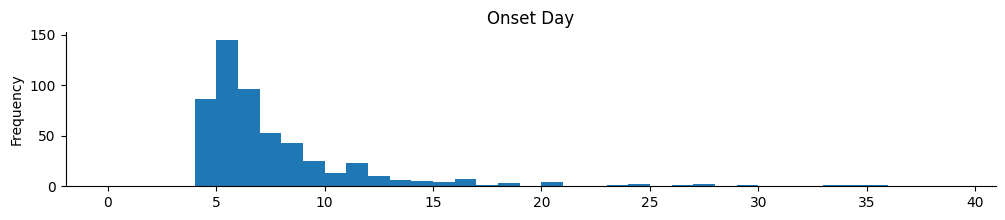

In [ ]:
def generate_sepsis_label_info(trum_cohort_info_df, candidates_df, is_report=False):
    """
    Generates a sepsis label and corresponding onset information for all the patients in the cohort table by analyzing the
    candidates DataFrame for infections and sepsis events.

    Parameters:
    - trum_cohort_info_df (pd.DataFrame): DataFrame containing the trauma cohort information with column 'hadm_id'.
    - candidates_df (pd.DataFrame): DataFrame containing sepsis onset candidate information with columns 'hadm_id', 'is_infection',
      'is_sepsis', 'onset_datetime', 'onset_day', 'cx_index', 'abx_index', 'sofa_index_1', and 'sofa_index_2'.
    - is_report (bool, optional): If True, prints the number of trauma patients, infections, and sepsis cases,
      as well as descriptive statistics and a histogram of 'onset_day'. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing sepsis label information including infection and sepsis flags, as well as sepsis onset details.
    """
    # Flag table
    flag_df = candidates_df.groupby("hadm_id")[['is_infection', 'is_sepsis']].max()
    # Onset table
    onset_df = candidates_df[candidates_df.is_sepsis == 1].groupby("hadm_id").head(1)[
        ['hadm_id', 'onset_datetime', 'onset_day', 'cx_index', 'abx_index', 'sofa_index_1', 'sofa_index_2']
    ]
    # Sepsis label table
    sepsis_label = trum_cohort_info_df[['hadm_id']].merge(flag_df, on='hadm_id', how='left').sort_values('hadm_id')
    sepsis_label.is_infection.fillna(0, inplace=True)
    sepsis_label.is_sepsis.fillna(0, inplace=True)
    sepsis_label_info = sepsis_label.merge(onset_df, on='hadm_id', how='left')

    # Print report if required
    if is_report:
        print(f'Number of trauma patients: {sepsis_label_info.shape[0]}')
        print(f'Number of infections: {sepsis_label_info.is_infection.sum()}')
        print(f'Number of sepsis cases: {sepsis_label_info.is_sepsis.sum()}')

        print('\nDisplay descriptive statistics for onset day')
        display(sepsis_label_info['onset_day'].describe())
        # Plot histogram of 'onset_day'
        sepsis_label_info['onset_day'].dropna().plot(kind='hist', bins=np.arange(0, 40), title='Onset Day', figsize=(12, 2))
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.show()


    return sepsis_label_info

sepsis_label_df = generate_sepsis_label_info(trum_cohort_info_df, candidates_df, is_report=True)

# Assign Sepsis Label

This section serves as the core of the project, integrating and executing the functions defined in previous sections. It will first load or generate the four preprocessed feature tables: cohort info, antibiotics (abx), cultures (cx), and SOFA scores. These tables are then used to identify patients who meet the sepsis criteria. If a patient meets the infection criteria, then the infection and sepsis flags, along with indices linking to the feature tables supporting these flags, will be treated as sepsis candidate information and saved in a candidate table. This candidate table, together with the trauma cohort, will be used to generate the sepsis label. The final label table will have one row per patient. If a patient has a positive sepsis flag, the table will also include indices linking to the feature tables to pinpoint the sepsis event. Note that a single patient may have multiple candidates that meet the sepsis criteria; however, we will only retain the earliest timestamp.



In [ ]:
from scripts.sepsis_onset_label_assignment import *


╔══════════════════════════════════╗
║        Preprocessing Data        ║
╚══════════════════════════════════╝
--------------Trauma Cohort Information--------------
Loading trauma cohort information...
Loaded 1570 trauma patients.

--------------Blood Culture Events-------------------
Loading blood culture events...
Loaded 8821 records for 1037 unique patients.
After processing (drop duplicates), 3826 unique records remain.

--------------Antibiotic Events----------------------
Loading antibiotic events...
Loaded 2780 records for 1006 unique patients.
After processing (drop duplicates), 2039 unique records remain.

--------------SOFA Scores----------------------------
Loading SOFA scores...
Loaded 433825 records for 1570 unique patients.
After processing, 433825 unique records remain.


╔══════════════════════════════════╗
║      Assigning Sepsis Labels     ║
╚══════════════════════════════════╝
Number of trauma patients: 1570
Number of infections: 729.0
Number of sepsis cases: 535.0


,onset_day
count,535.000000
mean,7.274766
std,4.603087
min,4.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,51.000000


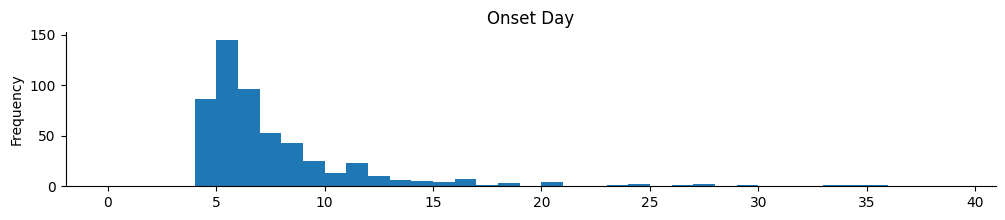

Saving sepsis label information at /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/processed/sepsis_label.csv


In [ ]:
def assign_sepsis_labels(project_path_obj, project_id):
    """
    Assigns sepsis labels to each patient in the cohort by executing the full data processing and analysis pipeline.
    This function integrates and runs all steps from data preprocessing to generating sepsis labels.

    Parameters:
    - project_path_obj (Path or str): The project path object or string representing the base path for the project files.
    - PROJECT_ID (str): The project ID for accessing BigQuery or other project-specific resources.

    Returns:
    - pd.DataFrame: A DataFrame containing sepsis label information including infection and sepsis flags, as well as sepsis onset details.
    """
    # Preprocess data
    print("\n╔══════════════════════════════════╗")
    print("║        Preprocessing Data        ║")
    print("╚══════════════════════════════════╝")
    trum_cohort_info_df, cx_df, abx_df, sofa_df = preprocess_data(project_path_obj, project_id)

    # Generate sepsis candidate information
    print("\n╔══════════════════════════════════╗")
    print("║      Assigning Sepsis Labels     ║")
    print("╚══════════════════════════════════╝")
    candidates_df = sepsis_onset_candidates(cx_df, abx_df, sofa_df)

    # Generate sepsis label information
    sepsis_label_df = generate_sepsis_label_info(trum_cohort_info_df, candidates_df,
                                                 is_report=True)
    # Saved
    print(f"Saving sepsis label information at {project_path_obj.sepsis_label_path}")
    sepsis_label_df.to_csv(project_path_obj.sepsis_label_path)

    return sepsis_label_df

sepsis_label_df = assign_sepsis_labels(project_path_obj, PROJECT_ID)

As demonstrated in the above section, among the 1,570 trauma patients (HADM_ID) analyzed, we identified 729 patients with suspected infections and 535 admissions with confirmed sepsis. Notably, the peak of sepsis onset occurs on the 5th day after hospital admission, which aligns with clinical experience.